In [2]:
import pickle
from os import path
import re
from nltk.tokenize import TweetTokenizer
import nltk
import csv
import numpy as np
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import CMUTweetTagger
from sklearn.metrics.pairwise import pairwise_distances
import scipy.cluster.hierarchy as sch
import fastcluster
from collections import Counter
import codecs
from datetime import datetime
from glob import glob
import pandas as pd
import sys
import langid
from guess_language import guess_language
import seaborn as sb
%matplotlib inline

In [10]:
DIR_DATA = path.join('data', 'twitter data')
DIR_GEO = path.join('data', 'geofiles')

# Read the files

In [11]:
# Read the splitted tsv files
all_files = glob(path.join(DIR_DATA, '*.tsv'))
if path.join(DIR_DATA, 'twex.tsv') in all_files:
    all_files.remove(path.join(DIR_DATA, 'twex.tsv'))

df_from_each_file = (pd.read_csv(
    file_name,
    sep="\t",
    encoding='utf-8',
    escapechar='\\',
    na_values='N',
    quoting=csv.QUOTE_NONE,
    header=None
    )
    for file_name in all_files)
print('Reading twex.tsv file...')
df = pd.concat(df_from_each_file, ignore_index=True)
print('is done!')

Reading twex.tsv file...
is done!


In [12]:
# Read the schema file
print('Reading schema.txt file...')
schema = pd.read_csv(
    path.join(DIR_DATA, 'schema.txt'),
    sep="\s+",
    header=None
)
print('is done!')

# Rename the dataframe columns
df.columns = schema[1]

Reading schema.txt file...
is done!


In [6]:
df['text'] = df['text'].apply(str)

In [8]:
# Our observations suggest that considering latitude/logitude columns is more accurate
df['latitude'].fillna(df['placeLatitude'], inplace=True)
df['longitude'].fillna(df['placeLongitude'], inplace=True)

# Just keep the important columns
df = df[['id', 'userId', 'createdAt', 'longitude', 'latitude', 'text']]

# Change the string in 'createdAt' column to datetime format
df['createdAt'] = pd.to_datetime(
    df['createdAt'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'
)

# Change the possible strings to numbers
df['id'] = df['id'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
df['userId'] = df['userId'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
df['longitude'] = df['longitude'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
df['latitude'] = df['latitude'].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [9]:
# Drop rows with NaN values in important columns
df = df.dropna(subset=['id', 'userId', 'createdAt', 'longitude', 'latitude'], how='any')

# Change the id and user id format to integer 
df['id'] = df['id'].astype(np.int64)
df['userId'] = df['userId'].astype(np.int64)

# Remove duplicated tweets with the same id (it is too time consuming!)
df = df.drop_duplicates(subset='id')

# Reset index
df = df.reset_index(drop=True)

In [10]:
df['language'] = np.nan
df.loc[:,'language'] =  df['text'].apply(lambda x: langid.classify(x)[0])

In [11]:
# Find the hashtags and users
df['Hashtags'] = df['text'].apply(lambda x:{tag.strip("#") for tag in x.split() if tag.startswith("#")})
df['users'] = df['text'].apply(lambda x:{tag.strip("@") for tag in x.split() if tag.startswith("@")})

In [12]:
# Add some columns for further analysis
df['day'] = df['createdAt'].map(lambda x: x.day)
df['month'] = df['createdAt'].map(lambda x: x.month)
df['year'] = df['createdAt'].map(lambda x: x.year)
daily_user = ['userId', 'year', 'month', 'day']
df['daily_tweets'] = df.groupby(by=daily_user)['userId'].transform('count')
df.reset_index(drop=True,inplace=True)

# Pre-processing

In [13]:
# Here we normalize the text, the code is taken from 
#https://github.com/heerme/twitter-topics/blob/master/twitter-topics-from-json-text-stream.py
def normalize_text(text):
    if type(text) is not str:
        print(text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(pic\.twitter\.com/[^\s]+))','', text)
    text = re.sub('@[^\s]+','', text)
    text = re.sub('#([^\s]+)', '', text)
    text = re.sub('[:;>?<=*+()/,\-#!$%\{˜|\}\[^_\\@\]1234567890’‘]',' ', text)
    text = re.sub('[\d]','', text)
    text = text.replace(".", '')
    text = text.replace("'", ' ')
    text = text.replace("\"", ' ')
    #text = text.replace("-", " ")
    #normalize some utf8 encoding
    text = text.replace("\x9d",' ').replace("\x8c",' ')
    text = text.replace("\xa0",' ')
    text = text.replace("\x9d\x92", ' ').replace("\x9a\xaa\xf0\x9f\x94\xb5", ' ').replace("\xf0\x9f\x91\x8d\x87\xba\xf0\x9f\x87\xb8", ' ').replace("\x9f",' ').replace("\x91\x8d",' ')
    text = text.replace("\xf0\x9f\x87\xba\xf0\x9f\x87\xb8",' ').replace("\xf0",' ').replace('\xf0x9f','').replace("\x9f\x91\x8d",' ').replace("\x87\xba\x87\xb8",' ')	
    text = text.replace("\xe2\x80\x94",' ').replace("\x9d\xa4",' ').replace("\x96\x91",' ').replace("\xe1\x91\xac\xc9\x8c\xce\x90\xc8\xbb\xef\xbb\x89\xd4\xbc\xef\xbb\x89\xc5\xa0\xc5\xa0\xc2\xb8",' ')
    text = text.replace("\xe2\x80\x99s", " ").replace("\xe2\x80\x98", ' ').replace("\xe2\x80\x99", ' ').replace("\xe2\x80\x9c", " ").replace("\xe2\x80\x9d", " ")
    text = text.replace("\xe2\x82\xac", " ").replace("\xc2\xa3", " ").replace("\xc2\xa0", " ").replace("\xc2\xab", " ").replace("\xf0\x9f\x94\xb4", " ").replace("\xf0\x9f\x87\xba\xf0\x9f\x87\xb8\xf0\x9f", "")
    return text

In [14]:
df.dropna(subset = ['text'],inplace=True)

In [15]:
df['processed_text'] = df['text'].apply(lambda x: normalize_text(x))
df.dropna(subset = ['processed_text'],inplace=True)
df.reset_index(inplace = True, drop = True)

In [16]:
#  filter the blank cells
filter_text = (df["processed_text"] != "") & (df["processed_text"] != " ") & (df["processed_text"] != "  ") \
    & (df["processed_text"] != "   ") 
df = df[filter_text]
df.reset_index(inplace=True,drop = True)

In [17]:
# As there are so many tweets about the weather, we postprocess the data by removing the tweets with removing them
Weather_words = ['falling', 'CForecast','humidity','pressure','wind','temperature ', 'Conditions', 'Cloudy', 'hpa', 'humidite', 'info',\
                 'km','Rain','fog','foggy','cloudy','kmh', 'mm', 'pluie', 'pression', 'temp','Temp', 'vent']
filtering = df['processed_text'].apply(lambda x:not any(w in Weather_words for w in x.split()))
df = df[filtering]
df.reset_index(drop=True,inplace=True)

## Remove stop words

In [18]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(nltk.corpus.stopwords.words('french'))
stop_words.extend(nltk.corpus.stopwords.words('italian'))
stop_words.extend(nltk.corpus.stopwords.words('german'))
stop_words.extend(['s','m','t','d','u','amp'])

In [19]:
df['processed_text'] = df['processed_text'].apply(lambda x: [item.lower() for item in x.split() if item.lower() not in stop_words and len(item)>1])

In [20]:
# Filter the tweets with less than 2 words
df = df[df['processed_text'].apply(lambda x: len(x)>1)]

In [21]:
df['processed_text'] = df['processed_text'].apply(lambda x:' '.join(x))

In [22]:
frequency = df.groupby('language').count()
frequency.sort('id', ascending=False,inplace = True)

/Users/salehi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [51]:
import matplotlib as mpl
import matplotlib.pylab as pylab


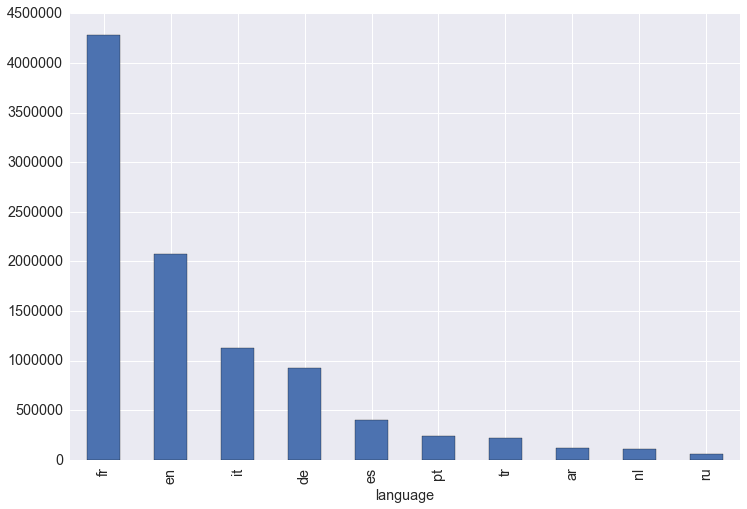

In [53]:

frequency.iloc[:10].id.plot.bar(figsize=(12,8))
label_size = 21
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':20,
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [1]:
# In order to be able to save data we split it to 20 parts and save it as a pickle

In [22]:
length_data = int(len(df)/10)
for i in range(10):
    df.iloc[i*length_data:(i+1)*length_data].to_pickle('data/twitter data/'+str(i)+'clean_data_event.pkl')
